In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import dataclasses

from kinetix import (
    Advection,
    Cells,
    Dispersion,
    FixedConcentrationBoundary,
    System,
    make_solver,
    declare_species,
    KineticReaction,
    reaction,
    SpatiallyConst,
    SpatiallyVarying
)

from dataclasses import dataclass

In [2]:
import pytensor.tensor as pt
import pytensor
import pymc as pm
import nutpie

In [3]:
jax.config.update("jax_enable_x64", True)

In [4]:
@reaction
class FirstOrderDecay(KineticReaction):
    decay_coefficient: jax.Array

    def rate(self, time, state, system):
        return self.decay_coefficient * state.reactive_tracer

    def stoichiometry(self, time, state, system):
        return {
            "reactive_tracer": -1,
        }
    
Species = declare_species(["tracer", "reactive_tracer"])

In [5]:
np.log(jnp.array(1 / 365) / (10 * 40 / 200))

np.float64(-6.593044534142437)

In [25]:
def make_system(decay_coefficient):
    species_is_mobile = Species(tracer=True, reactive_tracer=True)
    n_cells = 200
    reactions = [
        FirstOrderDecay(
            decay_coefficient=decay_coefficient
        )
    ]
    interface_areas = jnp.ones(n_cells + 1)
    cells = Cells.equally_spaced(10, n_cells, interface_area=interface_areas)
    dispersion = Dispersion.build(
        cells=cells,
        dispersivity=jnp.array(0.1),
        pore_diffusion=Species(
            tracer=jnp.array(1e-9 * 3600 * 24),
            reactive_tracer=jnp.array(1e-9 * 3600 * 24),
        ),
    )
    advection = Advection.build(
        limiter_type="upwind",
    )
    bcs = [
        FixedConcentrationBoundary(
            boundary="left",
            species_selector=lambda s: getattr(s, "tracer"),
            fixed_concentration=lambda t: jnp.array(10.0),
        ),
        FixedConcentrationBoundary(
            boundary="right",
            species_selector=lambda s: getattr(s, "tracer"),
            fixed_concentration=lambda t: jnp.array(3.0),
        ),
        FixedConcentrationBoundary(
            boundary="left",
            species_selector=lambda s: getattr(s, "reactive_tracer"),
            fixed_concentration=lambda t: jnp.array(1.0),
        ),
        FixedConcentrationBoundary(
            boundary="right",
            species_selector=lambda s: getattr(s, "reactive_tracer"),
            fixed_concentration=lambda t: jnp.array(3.0),
        )
    ]

    porosity= jnp.ones(n_cells) * 0.3
    #porosity = porosity.at[100:].set(0.1)
    return System.build(
        porosity=porosity,
        # velocity=lambda t: jnp.array(1 / 365) * jnp.sin(np.pi * 2 * 1 / 5000 * t),
        discharge=lambda t: jnp.array(1 / 365) * 0.3,
        cells=cells,
        advection=advection,
        dispersion=dispersion,
        species_is_mobile=species_is_mobile,
        bcs=bcs,
        reactions=reactions
    )

In [69]:
t_points = jnp.linspace(0, 8000, 123)
coords = {
    "time_dense": np.array(t_points),
}

with pm.Model(coords=coords) as model:
    decay_coefficient = pm.HalfNormal("k_dec", 0.01)
    system = make_system(decay_coefficient)
    model.add_coord("x", np.array(system.cells.centers))
    val0 = jnp.zeros(system.cells.n_cells)
    initial_state = Species(
        tracer=val0,
        reactive_tracer=val0
    )

    @pytensor.wrap_jax
    def solve_pt(y0, system):
        solve_fn_dense = make_solver(t_max=8000, t_points=t_points, rtol=1e-6, atol=1e-6, max_steps=10_000 * 100)
        return solve_fn_dense(y0, system).ys
    
    solution = solve_pt(initial_state, system)

    fields = dataclasses.fields(solution)
    for field in fields:
        pm.Deterministic(
            field.name,
            getattr(solution, field.name),
            dims=("time_dense", "x"),
        )
    pm.Normal("made_up_point", mu=solution.reactive_tracer[20, 40], sigma=0.1, observed=0.5)


In [58]:
import equinox as eqx

In [59]:
import diffrax
import optimistix

In [48]:
system = make_system(np.exp(-7))

initial_state = Species(
    tracer=val0,
    reactive_tracer=val0,
)

root_finder = optimistix.Dogleg(rtol=1e-9, atol=1e-9, norm=optimistix.two_norm)
solver = diffrax.Kvaerno3(root_find_max_steps=10, root_finder=root_finder)

solver = diffrax.Tsit5()
#adjoint = diffrax.BacksolveAdjoint()
solve_fn = make_solver(t_max=8000, t_points=t_points, rtol=1e-6, atol=1e-6, max_steps=10_000 * 100, solver=solver)
grad_solution = eqx.filter_jit(jax.grad(lambda initial_state, system: solve_fn(initial_state, system).ys.reactive_tracer[20, 40]))(initial_state, system)
solution = eqx.filter_jit(solve_fn)(initial_state, system)

In [7]:
with model:
    prior = pm.sample_prior_predictive(draws=50)

Sampling: [k_dec, made_up_point]


In [70]:
compiled = nutpie.compile_pymc_model(model, backend="jax", gradient_backend="jax")

In [81]:
compiled = nutpie.compile_pymc_model(model, backend="jax", gradient_backend="jax")
sampler = nutpie.sample(compiled, chains=2, blocking=False)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,55,0,1.89,1
,53,0,2.26,1


In [108]:
trace = sampler.inspect()

In [111]:
tr = sampler.abort()

In [109]:
import arviz as az

array([[<Axes: title={'center': 'k_dec_log__'}>,
        <Axes: title={'center': 'k_dec_log__'}>]], dtype=object)

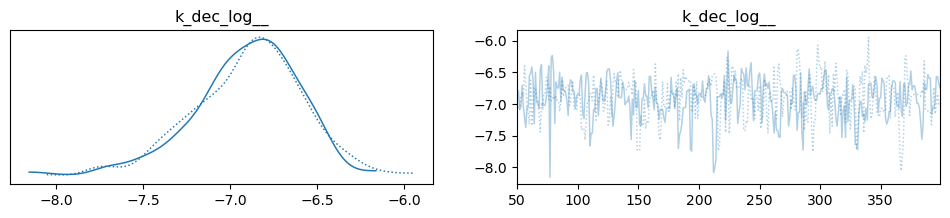

In [110]:
az.plot_trace(trace.warmup_posterior.k_dec_log__.isel(draw=slice(50, None)))

In [ ]:
sampler.abort()

In [ ]:
trace.warmup_sample_stats.diverging.plot.line(x="draw", hue="chain")

In [ ]:
trace.warmup_posterior.k_dec.isel(chain=0, draw=slice(100, None)).plot.line(x="draw")

In [ ]:
trace.warmup_sample_stats.step_size.plot.line(x="draw")
plt.yscale("log")

In [ ]:
trace.warmup_posterior.reactive_tracer.isel(chain=0, time_dense=20).plot.line(x="x", hue="draw", add_legend=False);

In [ ]:
prior.prior.reactive_tracer.isel(chain=0, time_dense=20).plot.line(x="x", hue="draw", add_legend=False);

In [ ]:
prior.prior.reactive_tracer.isel(chain=0, x=-1).plot.line(x="time_dense", hue="draw", add_legend=False);